# River Segmentation – Inference Notebook

This notebook demonstrates a complete **inference workflow for river segmentation** using a pre-trained deep learning model.

Specifically, it shows how to:

1. **Load** a multi-band raster file  
2. **Preprocess** the data by selecting relevant bands and preparing it for model input  
3. **Load** a pre-trained **U-Net** model trained for river segmentation  
4. **Run inference** to generate binary river masks from the raster data  

---

## Project structure

This work is part of a project split across **two GitHub repositories**:

1. **This repository**  
   - Handles raster loading, preprocessing, and deep-learning–based river segmentation  
   - Produces **binary river masks** as output  

2. **Vectorization & graph extraction repository**  
   - Converts large binary masks into **vectorized representations / river graphs**  

**Second repository:**  
[Insert link to second repository here](#)

---

> **Note**  
> This notebook focuses solely on **mask prediction**.  
> Vectorization and graph construction are handled in the companion repository.


In [1]:
import numpy as np
import sys
sys.path.append('..') 
import riverseg.preprocess.patch_preprocessing as riverpp
import riverseg.predict.predict as riverpred
import riverseg.core.device_management as rivercor
import riverseg.merge.merge as rivermerge

## Input band stacking schematic

The model expects the input tensor to be stacked along the **channel dimension**
in the following exact order:

| Channel | Band | Description                     | Resolution |
|--------:|------|---------------------------------|------------|
| 0 | VV  | Sentinel-1 Vertical-Vertical     | 10 m |
| 1 | VH  | Sentinel-1 Vertical-Horizontal  | 10 m |
| 2 | B2  | Blue                             | 10 m |
| 3 | B3  | Green                            | 10 m |
| 4 | B4  | Red                              | 10 m |
| 5 | B6  | Vegetation Red Edge              | 20 m |
| 6 | B7  | Vegetation Red Edge              | 20 m |
| 7 | B8  | Near Infrared (NIR)              | 10 m |
| 8 | B11 | Short-Wave Infrared (SWIR-1)     | 20 m |

This corresponds to an input tensor of shape:

```text
(C, H, W) = (9, height, width)


In [2]:
tif_path = r"..\data\sample\Bramaputra_example_bands.tif"
riverbands, _, _, _, _, = riverpp.open_tif(tif_path)

pp_riverbands = riverpp.preprocess_bands(riverbands)
pp_riverbands = riverpp.select_bands(pp_riverbands, [0,1,3,4,5,6,7,8,9])

print(pp_riverbands.shape)

(9, 256, 256)


To load a model the pretrained weights file is required. This can be downloaded from the following link:
 [https://drive.google.com/file/d/1gY2lPNDcrQGu5-Hqzlb54rHnCugfm_U2/view?usp=sharing](https://drive.google.com/file/d/1gY2lPNDcrQGu5-Hqzlb54rHnCugfm_U2/view?usp=sharing)

In [3]:
device = rivercor.get_device()
weight_path = r"..\weights\weights.pth"
model = riverpred.loadmodel(weight_path, device, 9, 1)

Device: cuda


With a loaded model the prediction can be found by running the following code:
> **Note**  
> The prediction is not yet binary, do this you can apply a threshold of 0.5 to the output mask.


In [4]:
prediction = riverpred.predict_river_extent(pp_riverbands, model)
binary_prediction = np.where(prediction > 0.5, 1, 0)

Below is a visual example of the predicted binary mask:

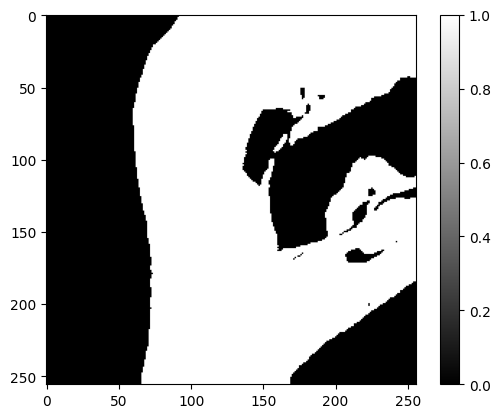

In [5]:
import matplotlib.pyplot as plt

# Visualize the binary array
plt.imshow(binary_prediction.squeeze(0), cmap='gray')
plt.colorbar()
plt.show()

# Processing entire folder of raster files
Below is an example of how to process an entire folder of raster files. The example saves the predicted masks as one single binary mask that covers the entire area.
In the data folder, place the raster files. An example folder can be found here: [https://drive.google.com/file/d/1wRKjmSd1u1xaioxfdKFjXPo95pcvbUsm/view?usp=sharing](https://drive.google.com/file/d/1wRKjmSd1u1xaioxfdKFjXPo95pcvbUsm/view?usp=sharing) \
The data is from the Brahmaputra river and captured in november 2024.


In [6]:
files_dir = r"..\data\Brahamaputra 2024-11-17\bands"
tif_paths = rivermerge.list_tif_paths(files_dir)

In [7]:
out_path = r"..\outputs\merged_mask.tif"
rivermerge.mosaic_predictions(tif_paths, model=model, out_path=out_path, threshold=0.5)
print("Wrote:", out_path)

Wrote: ..\outputs\merged_mask.tif
